<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/RF222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


# Get Data

In [19]:
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

data.reset_index(inplace=True)
data.head(10)

/tmp/ipython-input-3713280938.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
0,2013-01-01,9091.963867,9091.963867,9091.963867,9091.963867,0
1,2013-01-02,9323.320312,9325.948458,9043.769586,9151.558625,2277190
2,2013-01-03,9335.584961,9376.773190,9183.979586,9289.139468,1638359
3,2013-01-04,9049.022461,9131.397934,8955.254790,9113.871777,2154183
4,2013-01-07,9104.235352,9156.814818,9000.827867,9083.203370,1833898
5,2013-01-08,8928.092773,9148.052382,8900.926828,9013.973126,2221997
6,2013-01-09,9006.959961,9037.631716,8860.612820,9020.981279,2344840
7,2013-01-10,9091.963867,9091.963867,8906.180931,8982.422451,1564839
8,2013-01-11,9201.503906,9240.063009,9112.994478,9113.871176,3899959


# Feature engineer

In [20]:
df = data.copy()

# 1. Spreads
df['High_Low'] = df['High'] - df['Low']
df['Open_Close'] = df['Open'] - df['Close']

# 2. Moving Averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

# 3. Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# 4. Rolling Std (Volatility)
df['RollingStd_20'] = df['Close'].rolling(20).std()

# 5. Lag Features (Close & Volume)
for lag in range(1, 6):
    df[f'Close_t-{lag}'] = df['Close'].shift(lag)
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)
    df[f'Return_t-{lag}'] = df['Close'].pct_change(lag)

# 6. Relative Strength Index (RSI)
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 7. On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# 8. Moving Average Convergence Divergence (MACD)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 9. Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()

# 10. Average True Range (ATR)
df['H-L'] = df['High'] - df['Low']
df['H-C'] = abs(df['High'] - df['Close'].shift())
df['L-C'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# Drop NA rows
df.dropna(inplace=True)

# Target: 1 if next-day close > today’s close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)
df.head(10)


Price,Date,Close,High,Low,Open,Volume,High_Low,Open_Close,SMA_5,SMA_10,...,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14,Target
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,...,,,,,,,,,,
199,2013-10-07,4485.155273,4575.935774,4452.234872,4479.169746,1173121,123.700902,-5.985528,4500.716602,4591.397021,...,4838.440468,-222.953562,-231.006124,4695.545166,123.700902,80.806379,42.894522,123.700902,162.749471,0
200,2013-10-08,4451.235840,4556.980125,4449.240665,4556.980125,1274177,107.739460,105.744285,4497.125293,4562.067920,...,4809.758644,-219.541132,-228.713126,4660.230542,107.739460,71.824851,35.914609,107.739460,163.533290,0
201,2013-10-09,4380.407227,4470.190112,4355.467536,4464.204586,1392042,114.722576,83.797360,4467.995801,4531.242529,...,4777.954835,-220.015829,-226.973666,4627.858838,114.722576,18.954272,95.768304,114.722576,146.859246,1
202,2013-10-10,4442.257324,4468.194600,4301.597481,4375.418959,1802995,166.597120,-66.838365,4450.837012,4506.402588,...,4753.088353,-212.946528,-224.168239,4609.902319,166.597120,87.787374,78.809746,166.597120,139.662430,0
203,2013-10-11,4336.513184,4429.288828,4302.595206,4406.344314,1050501,126.693622,69.831130,4419.113770,4471.187793,...,4722.230933,-213.416592,-222.017909,4590.299707,126.693622,12.968496,139.662118,139.662118,134.959506,1
204,2013-10-14,4399.361816,4436.272562,4279.651291,4321.549975,2032833,156.621271,-77.811842,4401.955078,4451.335840,...,4698.314702,-206.339211,-218.882170,4578.079248,156.621271,99.759378,56.861893,156.621271,146.146739,0
205,2013-10-15,4336.513184,4406.344314,4271.669991,4372.426336,2081226,134.674322,35.913153,4379.010547,4438.067920,...,4671.514589,-203.456376,-215.797011,4561.519312,134.674322,6.982497,127.691825,134.674322,143.225175,1
206,2013-10-16,4369.434570,4488.147519,4344.494875,4366.441807,2451447,143.652643,-2.992763,4376.816016,4422.405908,...,4649.138292,-196.252947,-211.888198,4545.557983,143.652643,151.634335,7.981692,151.634335,143.724042,1
207,2013-10-17,4424.301758,4424.301758,4289.627409,4329.530920,7904643,134.674349,-94.770838,4373.224902,4412.030957,...,4632.483734,-183.995864,-206.309731,4521.665771,134.674349,54.867188,79.807161,134.674349,142.940226,1


# Train and split data

In [21]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

feature_pool = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_20','EMA_50',
    'RollingStd_20','High_Low','Open_Close',
    'Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'RSI_14',
    'OBV','EMA_12','EMA_26','MACD','Signal_Line','BB_Middle',
    'H-L','H-C','L-C','TR','ATR_14'
]
X_train_full = train[feature_pool]
y_train = train['Target']
X_test_full = test[feature_pool]
y_test = test['Target']


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Search for different combinations of features for highest accuracy

In [23]:
 import random

best_score = 0
best_features = None
best_model = None

for _ in range(100):
    r = random.randint(2, 10)
    combo = random.sample(feature_pool, r)

    X_train = X_train_full[list(combo)]
    X_test = X_test_full[list(combo)]

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    if acc > best_score:
        best_score = acc
        best_features = combo
        best_model = model

print("Best Accuracy:", best_score)
print("Best Feature Set:", best_features)


Best Accuracy: 0.5742971887550201
Best Feature Set: ['L-C', 'High', 'Volume_t-1', 'Signal_Line', 'SMA_200', 'Open_Close', 'Low', 'Open', 'Close', 'EMA_26']


# Confusion Matrix

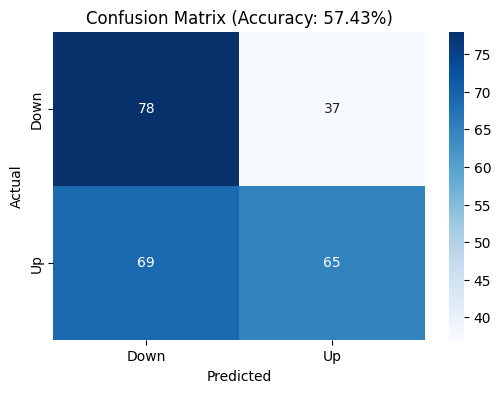

In [24]:
X_test_best = X_test_full[list(best_features)]
y_pred = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title(f"Confusion Matrix (Accuracy: {best_score:.2%})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


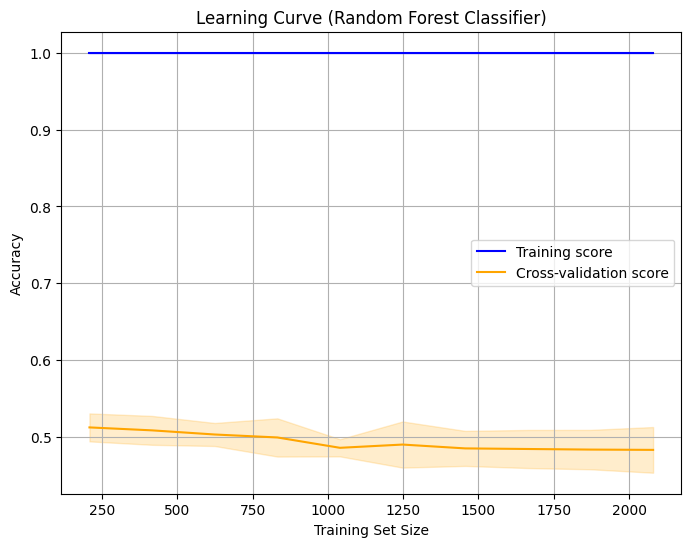

In [11]:
from sklearn.model_selection import learning_curve

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    X_train_full[list(best_features)],
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Random Forest Classifier)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()
